# Data block API for audio

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_05b import *
from exp.nb_07a import *
from exp.nb_07a import *
from exp.nb_07a import *
from exp.nb_08 import *
from exp.nb_08za import *
from exp.nb_08zb import *

In [3]:
#Export 
import re

In [4]:
from IPython.display import Audio # No cheat here ;-)

## Data Block classes

### AudioList
This class is responsible to contain a list of AudioData.

#### Internal mechanics:
The data are actually stored inside the property "items" of ItemList. When we call:
```python
    il = AudioList.from_folder(...)
    audiodata = il[0]
    assert AudioData == type(audioData)
```
What happens behind the scene is this:  
```python
    filePath = il.items[0] # retrive original data
    assert PosixPath == type(filePath)
    audioData = il.get(filePath) # try to "construct" the informaiton from path
    assert AudioData == type(audioData)
```




In [5]:
#Export 
def default_audio_loader(f):
    '''Default audio loader'''
    return AudioData.load(f)

In [6]:
#Export
class AudioList(ItemList):
    
    def __init__(self, items, loader=default_audio_loader, *args, **kwargs):
        super().__init__(items, *args, **kwargs)
        self.loader=default_audio_loader
            
    def get(self, item): 
        #Item is already AudioData
        if isinstance(item, AudioData): return item
        #Item is a path - ie: from_folder
        if isinstance(item, (Path, str)): return AudioData.load(str(item)) 
        #Item is a tuple
        if isinstance(item, (tuple, np.ndarray)): return AudioData(item[0],item[1])
        #Otherwise
        raise Exception(f"Format not supported: {type(item)}") 

    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
        
    @classmethod
    def from_folder(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = audio_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)

## Testing

### Sample data for test

In [7]:
path = getSampleAudioDataFiles()
good_sample = path.ls()[256] # arbitrary choice of file
example = AudioData.load(good_sample)

Working directory: /home/ste/.fastai/data/ST-AEDS-20180100_1-OS


In [8]:
def test_AudioList_from_folder():
    from pathlib import PosixPath # Used for test
    
    p = path

    #Create AudioList
    il = AudioList.from_folder(p)
    
    #Test an item
    i=4
    
    #Under the hood..
    filePath = il.items[i] # retrive original data
    assert PosixPath == type(filePath)
    audioData = il.get(filePath) # try to "construct" the informaiton from priginal data
    assert AudioData == type(audioData)
    
    #The easy way
    a = il[i]
    assert AudioData == type(a) 
    print(a.sig.shape, a.sr)
    display(a)
    
    print('DONE') # Ensure the test has been completed ;-)

test_AudioList_from_folder()

torch.Size([62720]) 16000


DONE


## Split Train and Validation

### Split function

In [9]:
#Export
def split_by_random_percentage(items, validPct=.2):
    from random import shuffle
    tmp = list(items) # clone
    shuffle(tmp) # shuffle
    split = int(len(tmp)*validPct)
    t = tmp[:-split]
    v = tmp[-split:]
    return t,v

In [10]:
def test_split_by_random_percentage():
    il = AudioList.from_folder(path)
    pct = .3
    train,valid = split_by_random_percentage(il.items,pct)
    assert list==type(train) #no magick
    assert list==type(valid) #no magick
    act_pct = float(len(valid))/float(len(train) + len(valid))
    print(f'Actual validation percentage: {act_pct}')
    assert act_pct <= pct
    print('DONE') # Ensure the test has been completed ;-)
    
test_split_by_random_percentage()

Actual validation percentage: 0.29984383133784487
DONE


### AudioSplitData

In [11]:
#Export
class AudioSplitData(SplitData): #WARNING: this method is generic and should be ported to SplitData
    @classmethod
    def split_by_random_percentage(cls, il, validPct=.2):
        lists = map(il.new, split_by_random_percentage(il.items, validPct=validPct))
        return cls(*lists)

In [12]:
def test_AudioSplitData_split_by_random_percentage():
    il = AudioList.from_folder(path)
    pct = .3
    sd = AudioSplitData.split_by_random_percentage(il,pct)
    assert AudioList==type(sd.train) #no magick
    assert AudioList==type(sd.valid) #no magick
    act_pct = float(len(sd.valid))/float(len(sd.train) + len(sd.valid))
    print(f'Actual validation percentage: {act_pct}')
    assert act_pct <= pct
    print('DONE') # Ensure the test has been completed ;-)

test_AudioSplitData_split_by_random_percentage()

Actual validation percentage: 0.29984383133784487
DONE


## Labeling

In [13]:
#Export
def re_labeler(fileName,pattern): 
    #thnx fat.ai ;-)
    fn = str(fileName) # Ensure is a string
    pat = re.compile(pattern)
    found = pat.search(fn)
    if found: return found.group(1)
    return None

In [14]:
def test_re_labeler():
    label_pattern = r'_([mf]\d+)_'    
    ans = re_labeler('/home/ste/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00174.wav',label_pattern)
    print(f'Found: {ans}')
    assert 'm0005' == ans
    assert None == re_labeler('wrong/path/to/file',label_pattern)
    print('DONE') # Ensure the test has been completed ;-)
    
test_re_labeler()

Found: m0005
DONE


## Transforms

In [15]:
sample = AudioData.load(path.ls()[0])
sample

↓ Original ↓


↓ Transformed ↓


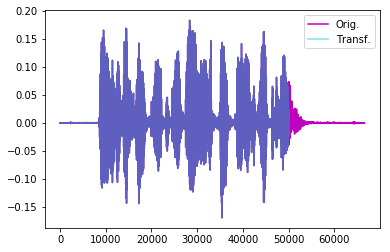

In [16]:
pad_sound = partial(tfm_pad_to_max, mx=50000)
try_audio_tfm(sample, pad_sound)

↓ Original ↓


↓ Transformed ↓


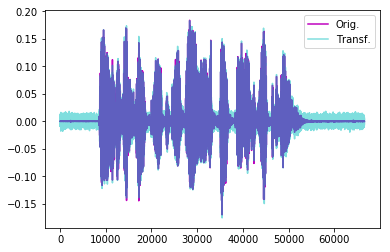

In [17]:
add_whitenoise = partial(tfm_add_white_noise, noise_scl=.005)
try_audio_tfm(sample, add_whitenoise)

'↓ Original ↓'

'Tensor shape=(1, 64, 444)'

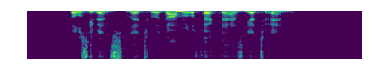

In [18]:
to_spectrogram = partial(tfm_spectro, n_mels=64, ws=300, n_fft=1024, to_db_scale=True)
#showTensorAsImage(to_spectrogram(sample))
try_spectro_tfm(sample, to_spectrogram)

## Label list with transforms (almost done)

In [19]:
#Export
def add_tfms_to_label_list(ll, tfmsl):
    ll.train.x.tfms = tfmsl[0]
    ll.valid.x.tfms = tfmsl[1]
    return ll

In [20]:
showLog = False
#train_tfms = [partial(tfm_log, msg='TRAIN TFMS: ', show=showLog), add_whitenoise, to_spectrogram]
#valid_tfms = [partial(tfm_log, msg='VALID TFMS: ', show=showLog), to_spectrogram]

train_tfms = [add_whitenoise, pad_sound, to_spectrogram]
valid_tfms = [pad_sound, to_spectrogram]

tfmsl = [train_tfms,valid_tfms] #list of transforms

In [21]:
label_pattern = r'_([mf]\d+)_'

In [22]:
il = AudioList.from_folder(path)
sd = AudioSplitData.split_by_random_percentage(il,.2)
ll = label_by_func(sd, partial(re_labeler,pattern=label_pattern), proc_y=CategoryProcessor())
ll = add_tfms_to_label_list(ll,tfmsl)

### Take a look at some samples...

In [23]:
display('Original data: ', il[0])

'Original data: '

'x'

'Tensor shape=(1, 64, 334)'

'y'

0

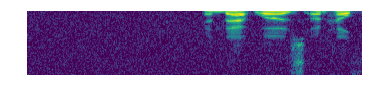

In [24]:
xy_sample = ll.train[0]
display('x')
showTensorAsImage(xy_sample[0])
display('y')
display(xy_sample[1])

## DataLoaders

In [25]:
bs = 32
train_dl,valid_dl = get_dls(ll.train,ll.valid,bs, num_workers=4)

In [26]:
x,y = next(iter(train_dl))

In [27]:
x.shape

torch.Size([32, 1, 64, 334])

In [28]:
y

tensor([2, 5, 1, 9, 7, 4, 9, 1, 9, 9, 4, 5, 0, 3, 4, 9, 3, 7, 0, 5, 7, 5, 1, 3,
        5, 9, 2, 1, 5, 9, 5, 6])

In [29]:
#Export 
def get_all_classes_for_label_list(ll):
    return list(set(ll.train.y.items + ll.valid.y.items))

In [30]:
get_all_classes_for_label_list(ll)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

## DataBunch

In [31]:
il = AudioList.from_folder(path)
sd = AudioSplitData.split_by_random_percentage(il,.2)
ll = label_by_func(sd, partial(re_labeler,pattern=label_pattern), proc_y=CategoryProcessor())
ll = add_tfms_to_label_list(ll,tfmsl)

spectro_channels = 1
num_classes = len(get_all_classes_for_label_list(ll))
data = ll.to_databunch(bs, c_in=spectro_channels, c_out=num_classes, num_workers=4)

# Train a Model

In [32]:
cbfs = [partial(AvgStatsCallback,accuracy),CudaCallback]

Normalize one batch...

In [33]:
m = x.mean((0,2,3)).cuda()
#s = x.std((0,2,3)).cuda() # Correct! New pytorch support std on multi dimensions...
s = torch.tensor(x.numpy().std((0,2,3))).cuda() # I've the old version of pytorch: too scary to update now ;-)

m,s

(tensor([-70.5868], device='cuda:0'), tensor([12.3209], device='cuda:0'))

### TODO: callback for normalization

In [34]:
nfs = [64,64,128,256]

In [35]:
sched = combine_scheds([0.3,0.7], cos_1cycle_anneal(0.1,0.3,0.05))

In [36]:
learn,run = get_learn_run(nfs, data, 0.2, conv_layer, cbs=cbfs+[
    partial(ParamScheduler, 'lr', sched)
])

In [37]:
#export
def model_summary(run, learn, data, find_all=False):
    xb,yb = get_batch(data.valid_dl, run)
    device = next(learn.model.parameters()).device#Model may not be on the GPU yet
    xb,yb = xb.to(device),yb.to(device)
    mods = find_modules(learn.model, is_lin_layer) if find_all else learn.model.children()
    f = lambda hook,mod,inp,out: print(f"{mod}\n{out.shape}\n")
    with Hooks(mods, f) as hooks: learn.model(xb)

In [41]:
# There is some problem with the AvgStatscallbeck... 
#model_summary(run, learn, data)

In [39]:
#??AvgStatsCallback

# Export

In [40]:
!python notebook2script.py 08zc_AudioDataBlock.ipynb

Converted 08zc_AudioDataBlock.ipynb to exp/nb_08zc.py
